In [102]:
from pymongo import MongoClient, ASCENDING, DESCENDING
import pytz
from datetime import datetime
import sys


# 连接到MongoDB
try:
    dbclient = MongoClient('busrv1.bud.zlzen.com', 27017, connectTimeoutMS=1000)
    # 调用server_info查询服务器状态，防止服务器异常并未连接成功
    dbclient.server_info()
except Exception as e:
    print('数据库连接失败')
    sys.exit(1)
    

# 从MongoDB读取指定数据，数据内容包括交易时间、Open、High、Low、Close和交易量
dbname = 'vntrader_1day_db'
colname = 'WHR.USD.STK.SMART'
colname = 'JD.USD.STK.SMART'
collection = dbclient[dbname][colname]
cursor = collection.find({
    'datetime': {
        '$gte': pytz.timezone('UTC').localize(datetime.strptime('19800101','%Y%m%d')),
        '$lte': pytz.timezone('UTC').localize(datetime.strptime('20180101','%Y%m%d')),
    }
}).sort('datetime', ASCENDING)

# 将读出的数据转变为列表，格式如下：
# [
#   ['date', 'open', 'high', 'low', 'close', 'Volume'],
#   ['03/17/1980', '15.63', '15.88', '15.5', '15.63', '337'], 
#   ['03/18/1980', '15.5', '15.5', '15.0', '15.5', '1913'],
#   ......
# ]
data_list = [['date', 'open', 'high', 'low', 'close', 'Volume']] +\
            [
                [
                    o['datetime'].strftime('%m/%d/%Y'),
                     str(o['open']), 
                     str(o['high']),
                     str(o['low']),
                     str(o['close']),
                     str(o['volume'])
                ] for o in cursor
            ]
print('前三个data_list=====', data_list[:3])
# print('data_list=====', data_list)



前三个data_list===== [['date', 'open', 'high', 'low', 'close', 'Volume'], ['05/22/2014', '21.75', '22.8', '20.24', '20.9', '831244'], ['05/23/2014', '20.9', '21.35', '19.94', '20.07', '204506']]


In [106]:

import numpy as np
import matplotlib.dates as mpd
import datetime


# 将交易日期转为matplotlib的日期格式（数字）
str2date =lambda x: mpd.date2num(datetime.datetime.strptime(x, '%m/%d/%Y').date())

# 列表第一个元素为字段名称列表，['date', 'open', 'high', 'low', 'close', 'Volume']
columns = data_list[0] 

# 构造蜡烛图显示用的数据源（列表），格式如下：交易日期（数字形式），Open、High、Low、Close。
# [
#   [722891.0, 15.63, 15.88, 15.5, 15.63], 
#   [722892.0, 15.5, 15.5, 15.0, 15.5], 
#   [722893.0, 15.63, 15.63, 15.5, 15.63],
#   ......
# ]
ohlc_data = [[str2date(d[0])] + [float(v) for v in d[1:-1]] for d in data_list[1:]]
ohlcv_data = [[str2date(d[0])] + [float(v) for v in d[1:]] for d in data_list[1:]]
dates, opens, highs, lows, closes, volumes = list(zip(*ohlcv_data))


print('前三个ohlcv_data=====',ohlcv_data[:3])



前三个ohlcv_data===== [[735375.0, 21.75, 22.8, 20.24, 20.9, 831244.0], [735376.0, 20.9, 21.35, 19.94, 20.07, 204506.0], [735380.0, 20.28, 23.08, 20.2, 23.06, 148865.0]]


In [107]:

_AA = 30
MAX_BAR_NUM = _AA if len(ohlc_data)>_AA else len(ohlc_data)

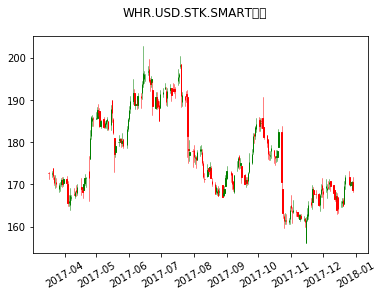

In [88]:
# 蜡烛图显示
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_finance as mpf


fig, ax = plt.subplots()
mpf.candlestick_ohlc(ax,ohlc_data[-MAX_BAR_NUM:],width=0.4,colorup='g',colordown='r')
ax.xaxis_date()
plt.setp(ax.get_xticklabels(), rotation=30)
fig.suptitle(colname + '日线')
ax.autoscale_view()

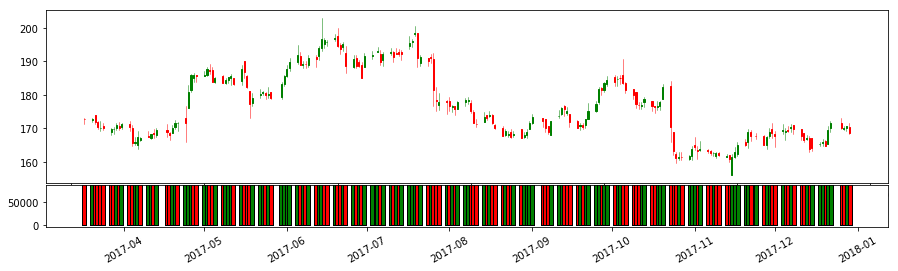

In [89]:
# 显示蜡烛图和交易量
fig = plt.figure(constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=1, left=0.05, right=2, hspace=0.05)
ax1 = fig.add_subplot(gs[:-1,:])
ax2 = fig.add_subplot(gs[-1, :])

mpf.candlestick_ohlc(ax1,ohlc_data[-MAX_BAR_NUM:],width=0.4,colorup='g',colordown='r')

# ax1.xaxis_date()
# ax1.set_xlabel('交易时间')
# plt.setp(ax1.get_xticklabels(), rotation=30)
ax1.autoscale_view()

mpf.volume_overlay3(ax2, ohlcv_data[-MAX_BAR_NUM:], colorup='g', colordown='r', width=4, alpha=1.0)
ax2.xaxis_date()
plt.setp(ax2.get_xticklabels(), rotation=30)
ax2.autoscale_view()





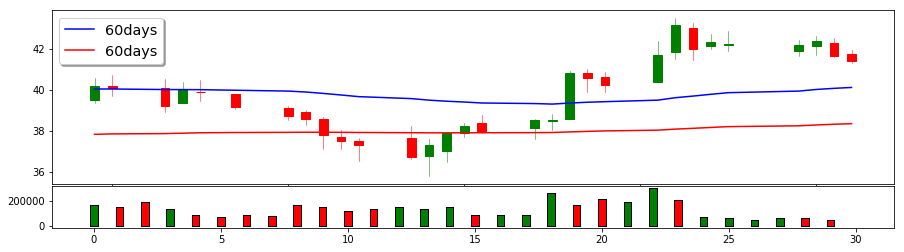

In [108]:
# 显示蜡烛图和交易量
fig = plt.figure(constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=1, left=0.05, right=2, hspace=0.05)
ax1 = fig.add_subplot(gs[:-1,:])
ax2 = fig.add_subplot(gs[-1, :])



mpf.candlestick_ohlc(ax1,ohlc_data[-MAX_BAR_NUM:],width=0.5,colorup='g',colordown='r')
ax1.autoscale_view()

mpf.volume_overlay(ax2, opens[-MAX_BAR_NUM:], closes[-MAX_BAR_NUM:], volumes[-MAX_BAR_NUM:],
                   colorup='g', colordown='r', width=0.3)
# ax2.xaxis_date()
# plt.setp(ax2.get_xticklabels(), rotation=30)
ax2.autoscale_view()


# 画均线


import talib
emaday60 = talib.EMA(np.array(closes), 60)
emaday200 = talib.EMA(np.array(closes), 200)

ax1.plot(dates[-MAX_BAR_NUM:], emaday60[-MAX_BAR_NUM:], 'b-', label='60days')
ax1.plot(dates[-MAX_BAR_NUM:], emaday200[-MAX_BAR_NUM:], 'r-', label='60days')
ax1.legend(loc='upper left', shadow=True, fontsize='x-large')
ax1.autoscale_view()
